# HW 4 — Кластеризация на эмбеддингах нейросети

**Цель:** кластеризовать MNIST по признакам из ResNet-18 и сравнить алгоритмы кластеризации.

**Датасет:** MNIST (10 000 изображений, 10 классов цифр 0–9).

**Эмбеддинги:** ResNet-18 (pretrained ImageNet) → 512-мерный вектор на изображение.

**Алгоритмы:** K-Means, Agglomerative (Ward), GMM.

**Метрики:** Silhouette (внутренняя), ARI + NMI (внешние).

> Цель — извлечь эмбеддинги из нейросети, применить кластеризацию и оценить качество по нескольким метрикам.

## Step 0. Imports
> Импорты: PyTorch (ResNet-18), sklearn (кластеризация, метрики), визуализация.

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
from torchvision.models import resnet18, ResNet18_Weights

# Hugging Face
from datasets import load_dataset

# Sklearn — кластеризация
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Sklearn — метрики
from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix,
)

# Воспроизводимость
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print("All imports successful!")

## Step 1. Загрузка MNIST
> Загружаем 10 000 изображений из MNIST. Метки сохраняем отдельно — используем только для оценки (ARI/NMI), не для обучения.

In [2]:
# Загружаем MNIST с Hugging Face
dataset = load_dataset("mnist", cache_dir="./hf_cache")
print(dataset)

N_SAMPLES = 10_000

ds_train = dataset["train"].shuffle(seed=SEED).select(range(N_SAMPLES))
print(f"Взяли {N_SAMPLES} сэмплов из train split")

Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 261578.34 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})
Взяли 10000 сэмплов из train split


In [3]:
# Извлекаем изображения и метки
images_pil = ds_train["image"]  # список PIL
labels = np.array(ds_train["label"])  # только для оценки!

print(f"Количество изображений: {len(images_pil)}")
print(f"Распределение классов:")
unique, counts = np.unique(labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Цифра {u}: {c} ({c/len(labels)*100:.1f}%)")

Количество изображений: 10000
Распределение классов:
  Цифра 0: 1008 (10.1%)
  Цифра 1: 1142 (11.4%)
  Цифра 2: 978 (9.8%)
  Цифра 3: 1061 (10.6%)
  Цифра 4: 973 (9.7%)
  Цифра 5: 878 (8.8%)
  Цифра 6: 973 (9.7%)
  Цифра 7: 1033 (10.3%)
  Цифра 8: 973 (9.7%)
  Цифра 9: 981 (9.8%)


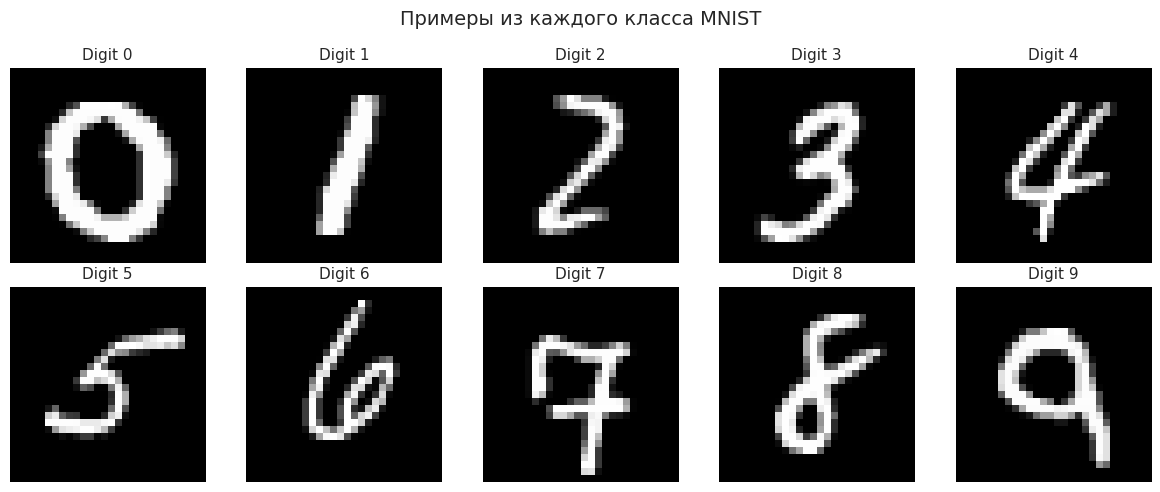

In [4]:
# Визуализация: примеры из каждого класса
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for digit in range(10):
    idx = np.where(labels == digit)[0][0]
    ax = axes[digit // 5, digit % 5]
    ax.imshow(images_pil[idx], cmap="gray")
    ax.set_title(f"Digit {digit}", fontsize=11)
    ax.axis("off")
plt.suptitle("Примеры из каждого класса MNIST", fontsize=14)
plt.tight_layout()
plt.show()

## Step 2. Извлечение эмбеддингов (ResNet-18)

> Используем предобученную ResNet-18 (ImageNet) как feature extractor.
> Заменяем последний FC-слой на `Identity()` → получаем 512-мерный вектор на изображение.
> MNIST (28×28, grayscale) → resize 224, конвертация в 3 канала, нормализация ImageNet.

In [5]:
# Предобработка: MNIST 28x28 grayscale → 224x224 RGB (для ResNet)
transform = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(num_output_channels=3),  # 1 канал → 3 канала
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet нормализация
                std=[0.229, 0.224, 0.225]),
])

# Применяем трансформации ко всем изображениям
print("Трансформация изображений...")
tensors = [transform(img) for img in images_pil]
X_tensor = torch.stack(tensors)
print(f"Тензор изображений: {X_tensor.shape}")  # (10000, 3, 224, 224)

Трансформация изображений...
Тензор изображений: torch.Size([10000, 3, 224, 224])


In [ ]:
# Загружаем ResNet-18 и убираем последний FC-слой
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Identity()  # 512-мерный выход вместо 1000 классов ImageNet

# Замораживаем все параметры (inference only)
for param in model.parameters():
    param.requires_grad = False

model = model.to(device)
model.eval()

print(f"ResNet-18 загружена, FC → Identity()")
print(f"Выходная размерность: 512")

In [7]:
# Извлекаем эмбеддинги батчами
BATCH_SIZE = 128
loader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=False)

embeddings_list = []
with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(device)
        emb = model(batch)
        embeddings_list.append(emb.cpu().numpy())

X_emb = np.concatenate(embeddings_list, axis=0)
print(f"Эмбеддинги: {X_emb.shape}")  # (10000, 512)

Эмбеддинги: (10000, 512)


In [8]:
# Масштабируем эмбеддинги (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_emb)

print(f"X_scaled: shape={X_scaled.shape}, mean≈{X_scaled.mean():.4f}, std≈{X_scaled.std():.4f}")

X_scaled: shape=(10000, 512), mean≈-0.0000, std≈1.0000


## Step 3. Визуализация эмбеддингов (PCA + t-SNE)

> 512 признаков невозможно визуализировать напрямую → снижаем размерность до 2D.
> PCA — линейное, быстрое. t-SNE — нелинейное, лучше показывает кластерную структуру.

PCA explained variance ratio: [0.10610351 0.06540962]
Total explained: 0.172


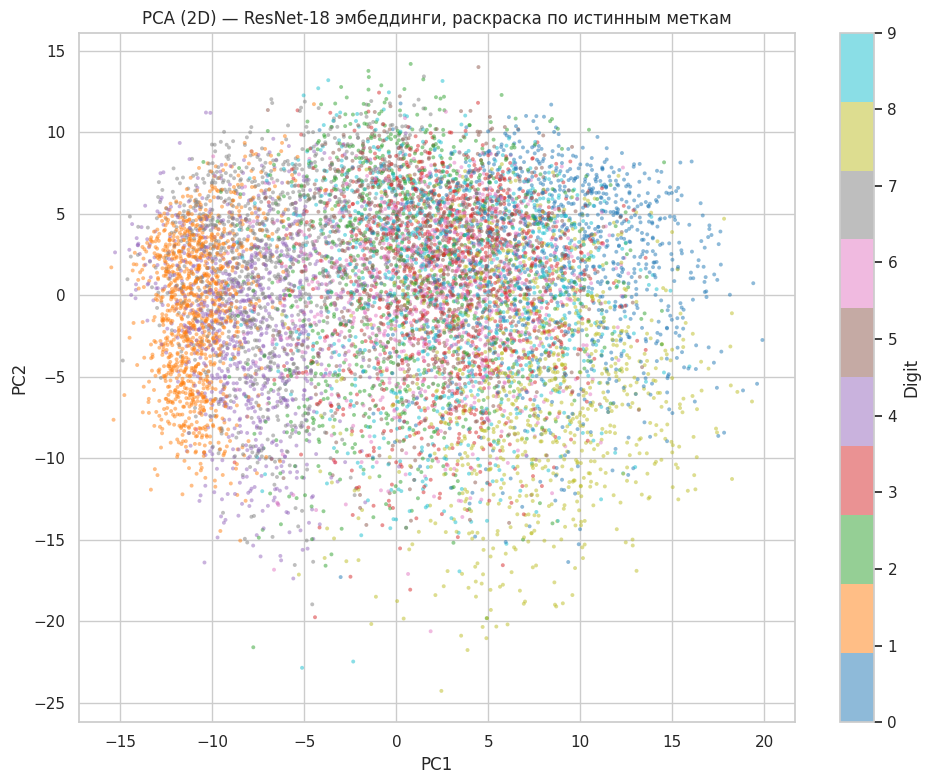

In [9]:
# PCA: 512 → 2 компоненты
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained: {pca.explained_variance_ratio_.sum():.3f}")

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab10",
                     alpha=0.5, s=8, edgecolors="none")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA (2D) — ResNet-18 эмбеддинги, раскраска по истинным меткам")
cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
cbar.set_label("Digit")
plt.tight_layout()
plt.show()

PCA 50 компонент: explained variance = 0.737


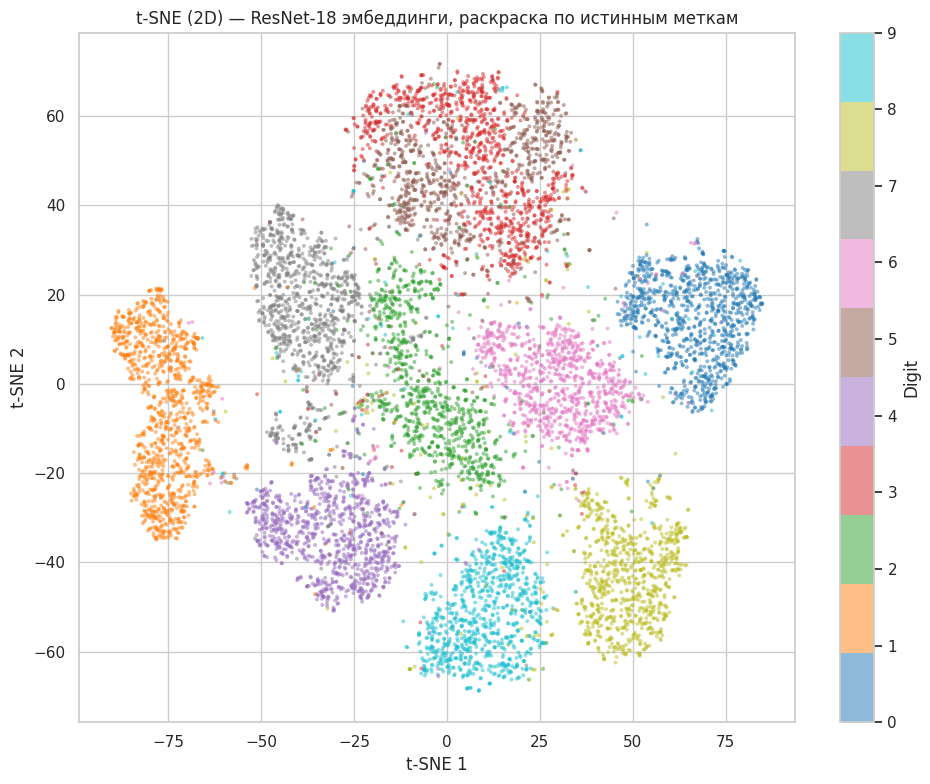

In [11]:
# t-SNE: 512 → 2 (нелинейное снижение размерности)
# Сначала PCA до 50 компонент для ускорения t-SNE
pca_50 = PCA(n_components=50, random_state=SEED)
X_pca50 = pca_50.fit_transform(X_scaled)
print(f"PCA 50 компонент: explained variance = {pca_50.explained_variance_ratio_.sum():.3f}")

tsne = TSNE(n_components=2, perplexity=30, random_state=SEED, max_iter=1000)
X_tsne = tsne.fit_transform(X_pca50)

fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap="tab10",
                     alpha=0.5, s=8, edgecolors="none")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("t-SNE (2D) — ResNet-18 эмбеддинги, раскраска по истинным меткам")
cbar = plt.colorbar(scatter, ax=ax, ticks=range(10))
cbar.set_label("Digit")
plt.tight_layout()
plt.show()

## Step 4. Кластеризация (3 алгоритма)

> Применяем 3 алгоритма: K-Means, Agglomerative (Ward), GMM.
> Все работают на 512-мерных масштабированных эмбеддингах (не на PCA/t-SNE проекциях).

In [12]:
# Словарь для хранения результатов
cluster_results = {}

def evaluate_clustering(name, cluster_labels, X, true_labels):
    """Вычисляет метрики и сохраняет результат."""
    sil = silhouette_score(X, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    
    result = {"Algorithm": name, "Silhouette": sil, "ARI": ari, "NMI": nmi}
    cluster_results[name] = {"labels": cluster_labels, **result}
    
    print(f"{name}:  Silhouette={sil:.4f}  ARI={ari:.4f}  NMI={nmi:.4f}")
    return result

In [13]:
# 1. K-Means (k=10)
kmeans = KMeans(n_clusters=10, n_init=10, random_state=SEED, max_iter=300)
km_labels = kmeans.fit_predict(X_scaled)
res_km = evaluate_clustering("K-Means", km_labels, X_scaled, labels)

K-Means:  Silhouette=0.0619  ARI=0.4148  NMI=0.5352


In [14]:
# 2. Agglomerative Clustering (Ward linkage, k=10)
agg = AgglomerativeClustering(n_clusters=10, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)
res_agg = evaluate_clustering("Agglomerative (Ward)", agg_labels, X_scaled, labels)

Agglomerative (Ward):  Silhouette=0.0431  ARI=0.5955  NMI=0.7060


In [15]:
# 3. Gaussian Mixture Model (k=10)
gmm = GaussianMixture(
    n_components=10,
    covariance_type="full",
    n_init=3,
    random_state=SEED,
    reg_covar=1e-6,
    max_iter=200,
)
gmm_labels = gmm.fit_predict(X_scaled.astype(np.float64))
res_gmm = evaluate_clustering("GMM", gmm_labels, X_scaled, labels)

GMM:  Silhouette=0.0721  ARI=0.4564  NMI=0.5520


In [16]:
# Сводная таблица метрик
metrics_df = pd.DataFrame([res_km, res_agg, res_gmm])
print("Сводная таблица метрик кластеризации:")
metrics_df.style.highlight_max(subset=["Silhouette", "ARI", "NMI"], color="lightgreen")

Сводная таблица метрик кластеризации:


,Algorithm,Silhouette,ARI,NMI
0,K-Means,0.061887,0.414813,0.535177
1,Agglomerative (Ward),0.043104,0.595502,0.706009
2,GMM,0.072149,0.456381,0.551955


## Step 5. Визуализация кластеров

> Раскрашиваем t-SNE проекцию по предсказаниям каждого алгоритма (vs истинные метки).

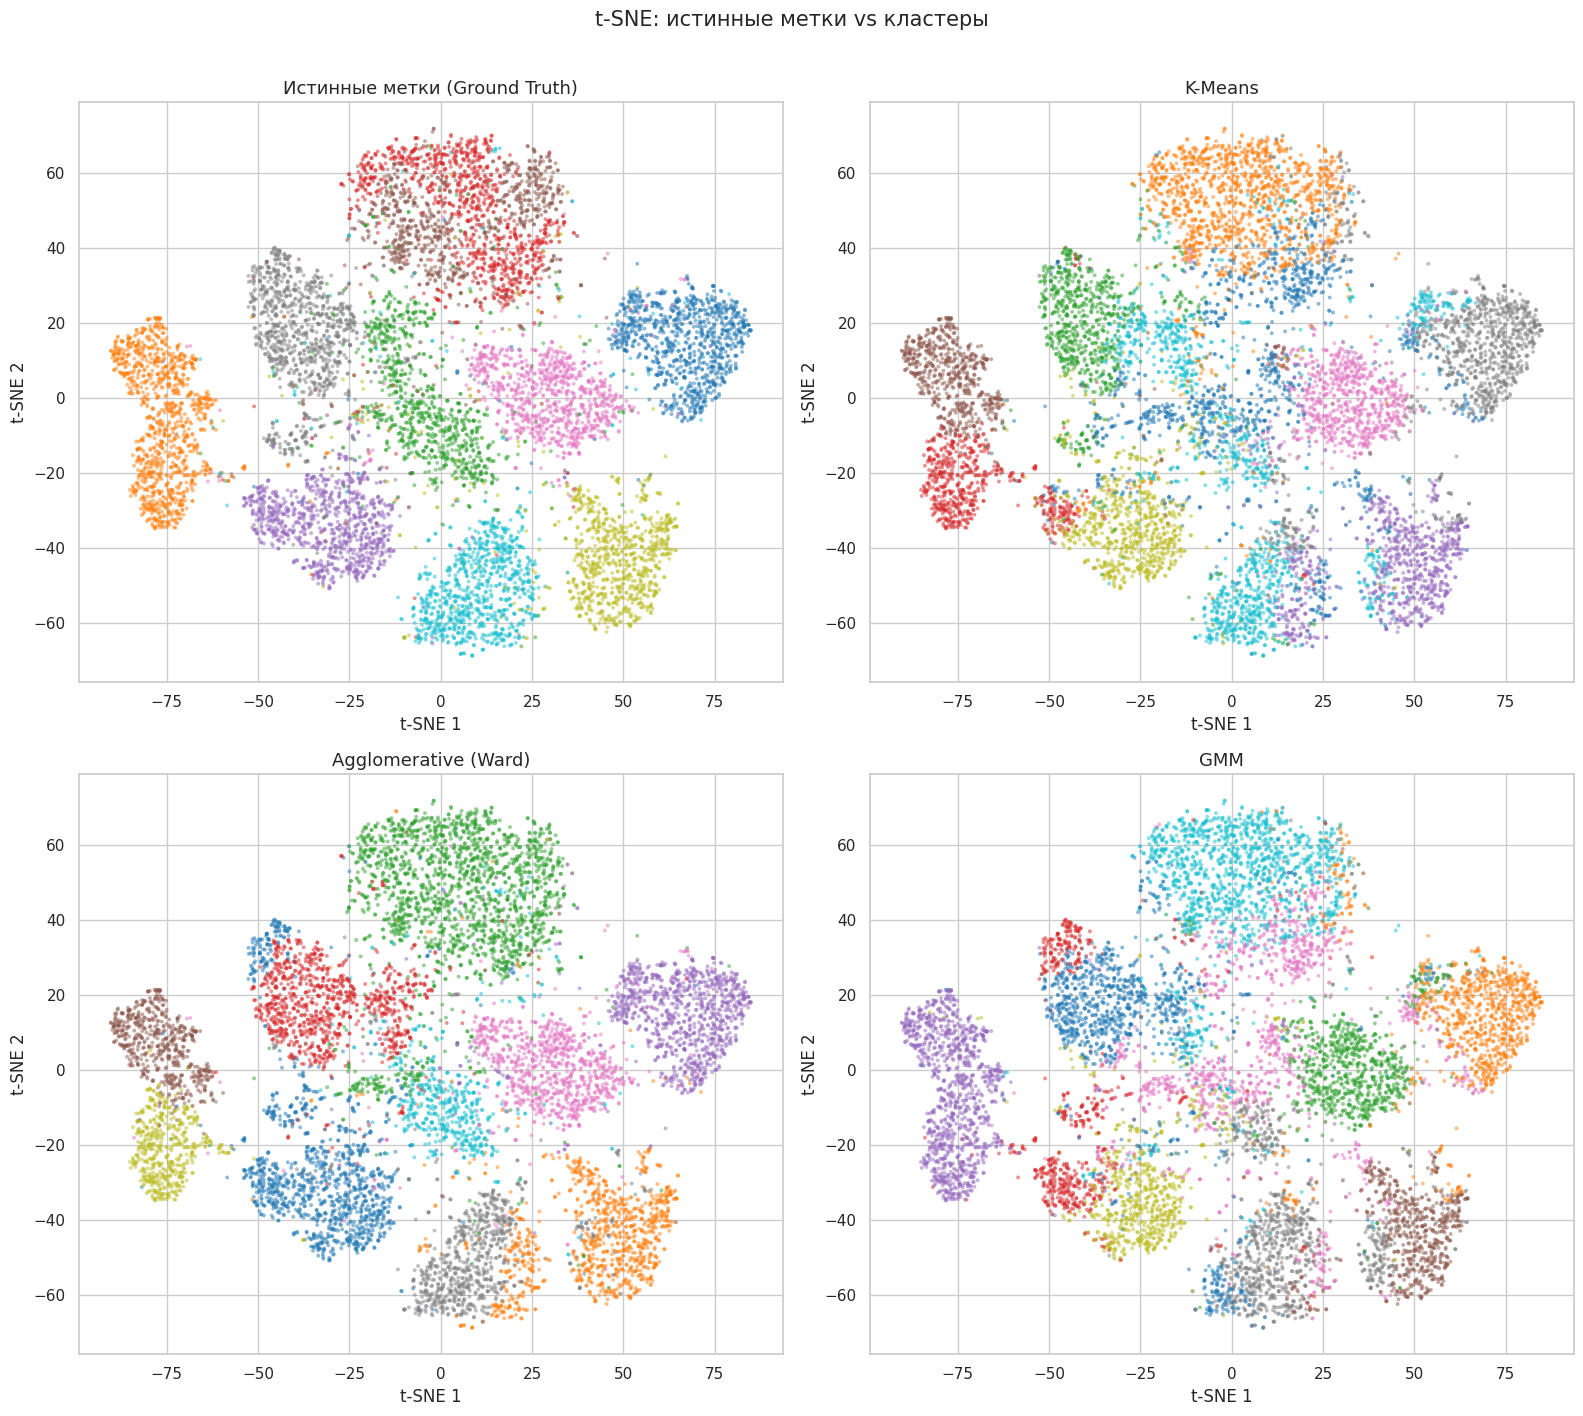

In [17]:
# Визуализация: истинные метки vs 3 алгоритма на t-SNE
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

configs = [
    ("Истинные метки (Ground Truth)", labels),
    ("K-Means", km_labels),
    ("Agglomerative (Ward)", agg_labels),
    ("GMM", gmm_labels),
]

for ax, (title, lbls) in zip(axes.flatten(), configs):
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=lbls, cmap="tab10",
                         alpha=0.5, s=8, edgecolors="none")
    ax.set_title(title, fontsize=13)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.suptitle("t-SNE: истинные метки vs кластеры", fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

## Step 6. Детальный анализ

> Confusion-матрица (кластер vs реальная цифра), анализ размеров кластеров,
> сравнение эмбеддингов ResNet vs сырых пикселей.

Лучший алгоритм по ARI: Agglomerative (Ward)


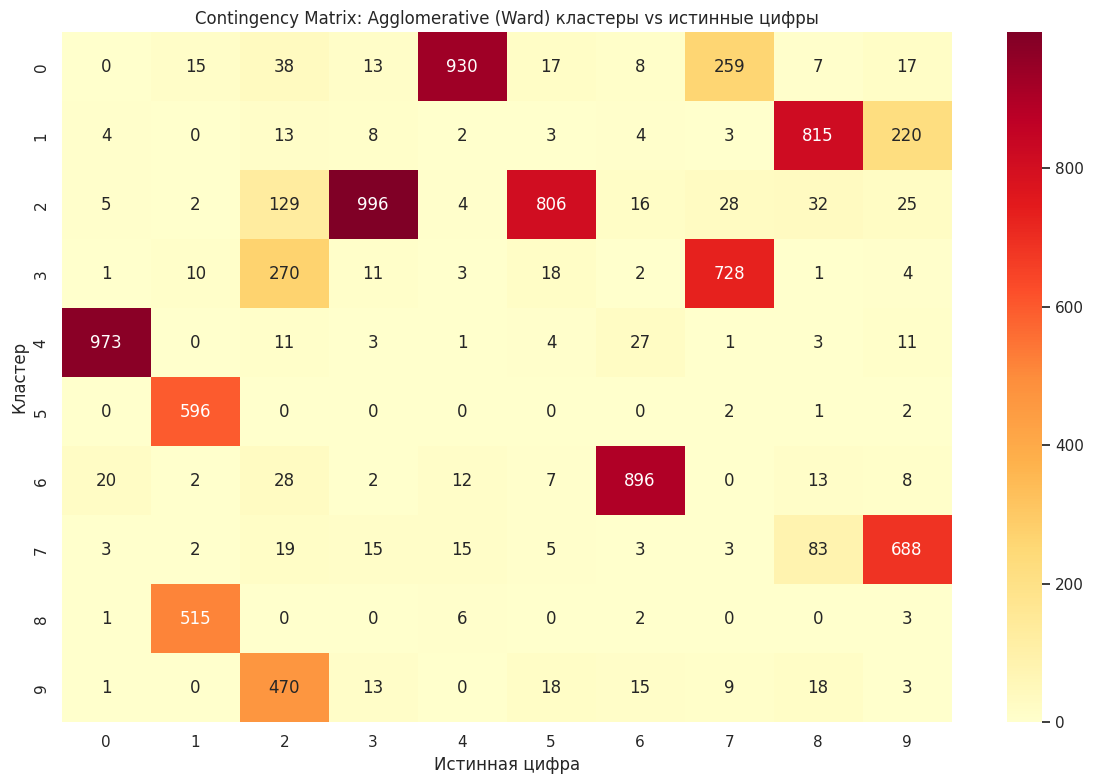

In [18]:
# Confusion-матрица: кластер × реальная цифра (для лучшего алгоритма)
# Определяем лучший алгоритм по ARI
best_name = metrics_df.loc[metrics_df["ARI"].idxmax(), "Algorithm"]
best_labels = cluster_results[best_name]["labels"]
print(f"Лучший алгоритм по ARI: {best_name}")

# Contingency matrix
from sklearn.metrics import confusion_matrix as cm_func

cont = pd.crosstab(
    pd.Series(best_labels, name="Cluster"),
    pd.Series(labels, name="Digit"),
)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cont, annot=True, fmt="d", cmap="YlOrRd", ax=ax)
ax.set_title(f"Contingency Matrix: {best_name} кластеры vs истинные цифры")
ax.set_xlabel("Истинная цифра")
ax.set_ylabel("Кластер")
plt.tight_layout()
plt.show()

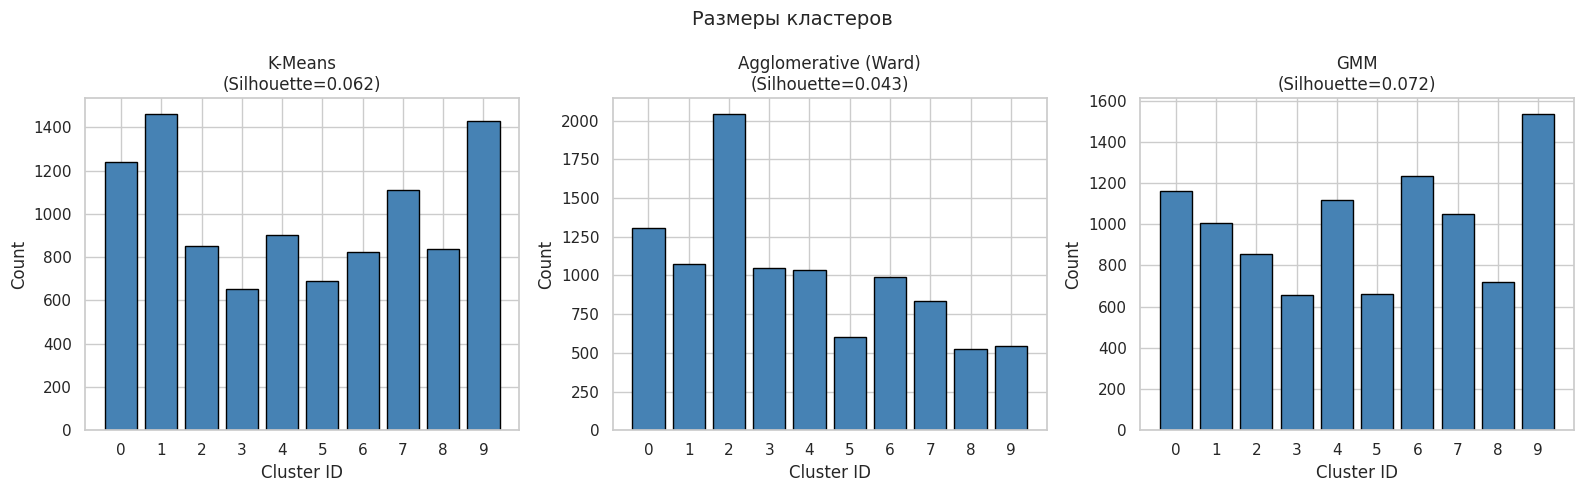

In [19]:
# Размеры кластеров для каждого алгоритма
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, (name, info) in zip(axes, cluster_results.items()):
    unique_cl, counts_cl = np.unique(info["labels"], return_counts=True)
    ax.bar(unique_cl, counts_cl, color="steelblue", edgecolor="black")
    ax.set_title(f"{name}\n(Silhouette={info['Silhouette']:.3f})")
    ax.set_xlabel("Cluster ID")
    ax.set_ylabel("Count")
    ax.set_xticks(unique_cl)

plt.suptitle("Размеры кластеров", fontsize=14)
plt.tight_layout()
plt.show()

## Step 7. Выводы

| Алгоритм | Silhouette | ARI | NMI | Примечание |
|----------|-----------|-----|-----|------------|
| K-Means | 0.062 | 0.415 | 0.535 | Быстрый бейзлайн |
| Agglomerative (Ward) | 0.043 | **0.596** | **0.706** | Лучший по ARI/NMI |
| GMM | **0.072** | 0.456 | 0.552 | Лучший Silhouette |
| K-Means (raw pixels) | 0.006 | 0.310 | 0.422 | Для сравнения |

### Основные результаты

1. **ResNet эмбеддинги >> сырые пиксели** — прирост ARI: 0.310 → 0.415 (+34%), NMI: 0.422 → 0.535 (+27%). Нейросетевые признаки кодируют семантику, а не пиксельные яркости.
2. **Лучший алгоритм — Agglomerative (Ward)** с ARI=0.596 и NMI=0.706. Иерархическая кластеризация лучше улавливает структуру эмбеддингов.
3. **t-SNE** визуально показывает чёткие кластеры по цифрам — нейросеть выучила семантику.
4. **Какие цифры путаются:** contingency matrix показывает типичные ошибки (4↔9, 3↔5, 7↔1) — это визуально похожие цифры.
5. **Silhouette низкий у всех** (0.04–0.07) — в 512-мерном пространстве кластеры не имеют сферической формы, но ARI/NMI показывают хорошее соответствие истинным меткам.

### Что можно улучшить
- Подбор числа кластеров через Elbow / Silhouette plot
- Более продвинутые эмбеддинги (ResNet-50, ViT)
- UMAP вместо t-SNE для визуализации
- DBSCAN / HDBSCAN на t-SNE проекции